# SUPPORT VECTOR MACHINE ALGORITHM on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading,Cleaning & Preprocessing the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

####Import all Required Libraries 

In [1]:
%matplotlib inline
import warnings
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Pull the dataset from Google Drive & mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Connect to Database and execute the query

In [3]:
con = sqlite3.connect("/content/drive/My Drive/Colab Notebooks/database.sqlite")

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""",con);
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning & Preparation 

In [4]:
filtered_data.shape

def partition(x):
  if x < 3 :
    return 'negative'
  return 'positive'

actualScore=filtered_data['Score']
positive_negative=actualScore.map(partition)
filtered_data['Score']=positive_negative
print("Number of datapoints",filtered_data.shape)
filtered_data.head(3)

Number of datapoints (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head(3)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [9]:
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stopping_words = set(stopwords.words('english'))
print(stopping_words)

{'itself', 'against', 'here', "didn't", 'myself', 'under', "you're", 'most', 'no', 'all', "should've", 'will', 'weren', 'them', 'isn', 's', 'having', 'how', 'were', 'but', "she's", 'has', 'through', 'between', 'where', 'their', 'me', 'you', 'his', 'ours', 'there', 'doesn', 'our', 'out', 'my', 'a', 'himself', 'any', 'be', 'if', 'too', 'from', 'few', 'd', 'do', 'before', 'when', 'themselves', 'are', 'being', 'of', "hadn't", 'did', 'him', 'into', 'in', "needn't", "you'd", 'during', 'm', "isn't", 'is', 'o', 't', 'over', 'was', "couldn't", 'while', 'who', 'just', 'off', 'doing', 'does', 'for', 'then', "you'll", 'those', 'can', 'y', 'same', "mightn't", 'some', 'have', "don't", 'needn', "haven't", 'or', 'each', 'she', 'yourselves', 'i', 'both', 'these', 'shan', 'your', 'nor', "shouldn't", 'on', 'herself', 'with', 'at', 'don', 'as', 'ma', 'he', 'down', "you've", 've', 'own', 'an', 'it', "wasn't", 'because', "mustn't", 'didn', 'won', 'hasn', 'mightn', 'below', 'about', 'such', "weren't", 'ourse

In [0]:
def clean_html(text):
    clean_r = re.compile('<,*?>')
    clean_text = re.sub(clean_r,'',text)
    return clean_text

def Clean_punc(text):
    clean_sentence = re.sub(r'[?|!|\'|"|#]',r' ',text)
    clean_data = re.sub(r'[.|,|)|(|\|/)]',r' ',clean_sentence)
    return clean_data

In [15]:
from tqdm import tqdm
import os
import pdb
import pickle

from tqdm import tqdm
import os
import pdb
import pickle

stem_no = nltk.stem.SnowballStemmer('english')

if not os.path.isfile('final_data.sqlite'):
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for i,sentence in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        sent_without_html_tags=clean_html(sentence)
        #pdb.set_trace()
        for w in sent_without_html_tags.split():
            for cleaned_words in Clean_punc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                    if(cleaned_words.lower() not in stopping_words) :
                        stemming=(stem_no.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stemming)
                        if(final_data['Score'].values)[i]=='positive':
                            all_positive_words.append(stemming)
                        if(final_data['Score'].values)[i]=='negative':
                            all_negative_words.append(stemming)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        
    final_data['Cleaned_text']=final_string
    final_data['Cleaned_text']=final_data['Cleaned_text'].str.decode("utf-8")    
    
    conn = sqlite3.connect('final_data.sqlite')
    cursor=conn.cursor
    conn.text_factory = str
    final_data.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl','wb') as f :
        pickle.dump(all_positive_words,f)
    with open('negative_words.pkl','wb') as f :
        pickle.dump(all_negative_words,f)

100%|██████████| 364171/364171 [06:07<00:00, 991.13it/s]


In [0]:
final_data['total_words'] = [len(x.split()) for x in final_data['Cleaned_text'].tolist()]

In [0]:
final_data.sort_values(by=['Time'], inplace=True, ascending=True)

In [18]:
final_data_100K=final_data[0:100000]
amazon_polarity_labels=final_data_100K['Score'].values
final_data_100K.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,30


In [0]:
final_data_40K = final_data[0:30000]
amazon_polarity_labels_40K = final_data_40K['Score'].values

### Split the dataset in Train , Test & Cross Validation

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_1,X_Test,Y_1,Y_Test = train_test_split(final_data_100K,amazon_polarity_labels,test_size=0.2,random_state=0)
X_Train,X_CV,Y_Train,Y_CV = train_test_split(X_1,Y_1,test_size=0.2)

## APPLY BAG OF WORDS VECTORIZATION TECHNIQUE USING LINEAR SVM  (SGDCLASSIFIER) TO FIND THE BEST ALPHA 

In [21]:
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


count_vector=CountVectorizer(min_df=1)
X_Train_data_bow=(count_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_bow=(count_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_bow=(count_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_bow.shape, Y_Train.shape)
print(X_CV_data_bow.shape, Y_CV.shape)
print(X_Test_data_bow.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 29463) (64000,)
(16000, 29463) (16000,)
(20000, 29463) (20000,)


In [0]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

def SVM_Linear_SVM(x_training_data,y_training_data,regularization):
  grid_params = { 'alpha' : [10**x for x in range(-4,5)]              
                 }
  LinearSVM = SGDClassifier(loss='hinge',penalty=regularization,random_state=None, class_weight=None)
  clf=GridSearchCV(LinearSVM,grid_params,scoring='roc_auc',return_train_score=True,cv=10)
  clf.fit(x_training_data,y_training_data)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_alpha'])
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']
  best_alpha =  results['param_alpha']
  #print(type(alpha))
  #print(alpha)
  #log_c=np.log10(list(results["param_C"]))
  print(clf.best_score_)
  print(clf.best_params_)
  plt.plot(best_alpha, train_auc, label='Train AUC')
  plt.plot(best_alpha, cv_auc, label='CV AUC')
  plt.scatter(best_alpha, train_auc, label='Train AUC points')
  plt.scatter(best_alpha, cv_auc, label='CV AUC points')
  plt.legend()
  plt.xlabel("Alpha : hyperparameter")
  plt.ylabel("AUC")
  plt.title("Hyper parameter Vs AUC plot")
  plt.grid()
  plt.show()
  return results,clf,LinearSVM

### Call Linear SVM using L2 Regularization

0.9266877065638912
{'alpha': 0.001}


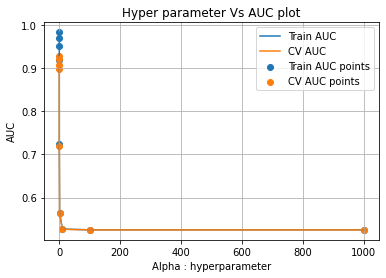

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.228909,0.056521,0.016896,0.001494,1e-05,{'alpha': 1e-05},0.905648,0.906011,0.893473,0.883739,0.896256,0.901730,0.896918,0.896734,0.906520,0.900492,0.898752,0.006629,4,0.982920,0.983100,0.983789,0.982390,0.982178,0.982703,0.983500,0.982523,0.982630,0.982856,0.982859,0.000470
1,0.641934,0.049558,0.016620,0.000650,0.0001,{'alpha': 0.0001},0.923277,0.926389,0.914071,0.913874,0.919699,0.921160,0.920387,0.921208,0.927508,0.917789,0.920536,0.004309,2,0.969272,0.970882,0.969797,0.969108,0.967741,0.969199,0.969654,0.968942,0.969344,0.969778,0.969372,0.000752
2,0.377793,0.019492,0.016994,0.001798,0.001,{'alpha': 0.001},0.930186,0.930582,0.920052,0.922287,0.931949,0.926963,0.924441,0.928616,0.929192,0.922609,0.926688,0.003876,1,0.950028,0.950512,0.951244,0.951087,0.950034,0.951242,0.950395,0.950647,0.950461,0.951639,0.950729,0.000519
3,0.297809,0.009442,0.016568,0.000745,0.01,{'alpha': 0.01},0.907816,0.909699,0.899714,0.900818,0.916499,0.911147,0.894876,0.910433,0.912018,0.896136,0.905915,0.007049,3,0.917456,0.919058,0.919244,0.917893,0.915734,0.917325,0.918521,0.919174,0.919189,0.917849,0.918144,0.001070
4,0.297083,0.006493,0.017016,0.001693,0.1,{'alpha': 0.1},0.704151,0.728275,0.715915,0.703160,0.742848,0.724745,0.714167,0.726055,0.731735,0.710802,0.720185,0.012071,5,0.730834,0.724176,0.724655,0.723389,0.723319,0.722480,0.723035,0.723863,0.723881,0.723227,0.724286,0.002260


In [23]:
results,best_alpha,linear_svm = SVM_Linear_SVM(X_Train_data_bow,Y_Train,'l2')
results.head()

#### Got Best Alpha = 0.001 and AUC SCORE = 0.9266 ON TRAINING DATA

In [0]:
def Find_best_Alpha(best_alpha) :
  best_Alpha = best_alpha.best_params_
  best_alpha=best_Alpha.get("alpha")
  print(best_alpha)
  return best_alpha

In [25]:
best_alpha = Find_best_Alpha(best_alpha)

0.001


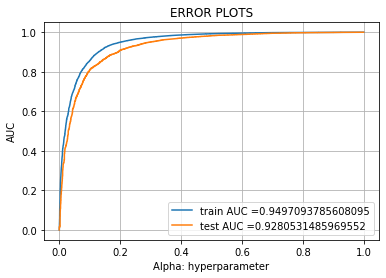

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

linear_svm = SGDClassifier(loss='hinge',penalty='l2',random_state=None, class_weight=None,alpha=best_alpha)
clf=linear_svm.fit(X_Train_data_bow,Y_Train)
calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
model_m=calibrated_model.fit(X_Train_data_bow,Y_Train)
pred_test_data=linear_svm.predict(X_Test_data_bow)
y_train_predicted_prob = model_m.predict_proba(X_Train_data_bow)[:,1]
y_test_predicted_prob=model_m.predict_proba(X_Test_data_bow)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### ON TEST DATA WE GOT AUC AS 0.9280 FOR ALPHA = 0.001

In [27]:
feature_names = count_vector.get_feature_names()
print(feature_names)
coefs_with_fns = sorted(zip(linear_svm.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

['aaa', 'aaaaaaaaagghh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaah', 'aaahhhhhh', 'aachen', 'aacur', 'aadp', 'aafco', 'aah', 'aahh', 'aalmost', 'aand', 'aardvark', 'ab', 'aback', 'abandon', 'abaolut', 'abattoir', 'abba', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abcstor', 'abd', 'abdomen', 'abdomin', 'aber', 'aberdeen', 'abhor', 'abhorr', 'abi', 'abid', 'abigirl', 'abil', 'abit', 'abita', 'abj', 'abl', 'abliti', 'abnorm', 'aboard', 'abod', 'abomin', 'abondanza', 'aboout', 'aboslut', 'abosolut', 'abot', 'aboth', 'abou', 'abound', 'abour', 'abouy', 'abouyt', 'abovement', 'aboveour', 'abpv', 'abras', 'abreva', 'abrevi', 'abroad', 'abrupt', 'abruzzo', 'abscess', 'abscond', 'absenc', 'absens', 'absensc', 'absent', 'absolu', 'absolulti', 'absolut', 'absolutali', 'absoluteki', 'absolutel', 'absolutelli', 'absolutelti', 'absolutey', 'absolutley', 'absolutuley', 'absolv', 'absorb', 'absorbt', 'absorpt', 'absoult', 'absoulut', 'absout', 'abstain', 'abstin', 'abstract', 'absulut', 'absurd', 'a

[((-1.058942800585861, 'worst'), (0.5322610283239771, 'delici')),
 ((-0.7799799974810454, 'disappoint'), (0.4731209140657581, 'excel')),
 ((-0.7665897829320187, 'terribl'), (0.4641941043664035, 'amaz')),
 ((-0.7152606271607351, 'horribl'), (0.45303559224220846, 'best')),
 ((-0.7074496686738002, 'threw'), (0.4374136752683411, 'perfect')),
 ((-0.698522858974446, 'aw'), (0.4240234607193107, 'great')),
 ((-0.6873643468502516, 'return'), (0.3648833464610924, 'addict')),
 ((-0.6159498692554216, 'tasteless'), (0.3570723879741582, 'nice')),
 ((-0.6025596547063876, 'bland'), (0.3548406855493194, 'awesom')),
 ((-0.5858218865201033, 'stale'), (0.3314078100885153, 'satisfi')),
 ((-0.5032488968010768, 'unfortun'), (0.32582855402641864, 'wonder')),
 ((-0.49990134316381896, 'disgust'), (0.32359685160158047, 'yummi')),
 ((-0.4932062358893016, 'poor'), (0.31578589311464605, 'smooth')),
 ((-0.482047723765109, 'money'), (0.3113224882649689, 'beat')),
 ((-0.4697733604285002, 'stuck'), (0.3057432322028735,

### TOP 20 POSITIVE & NEGATIVE FEATURES

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_Test,y_test_predicted_prob)

0.9280531485969552

In [29]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.82      0.44      0.57      2457
    positive       0.93      0.99      0.96     17543

    accuracy                           0.92     20000
   macro avg       0.87      0.71      0.76     20000
weighted avg       0.91      0.92      0.91     20000

[[ 1069  1388]
 [  237 17306]]


### SVM on Amazon Fine Food Review using L1 Regularization

0.8839167307373945
{'alpha': 0.0001}


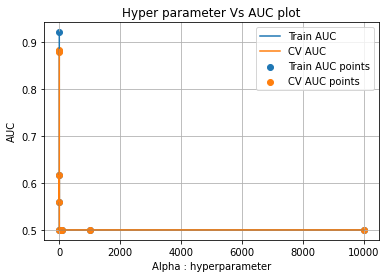

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,4.734316,0.663837,0.019478,0.000709,0.0001,{'alpha': 0.0001},0.893648,0.890219,0.875887,0.878993,0.884310,0.882227,0.877010,0.882301,0.892839,0.881733,0.883917,0.006007,1,0.920511,0.919138,0.922435,0.917970,0.920574,0.921928,0.919743,0.925238,0.922901,0.918122,0.920856,0.002173
1,0.740307,0.322096,0.019451,0.000378,0.001,{'alpha': 0.001},0.881980,0.885111,0.869931,0.883527,0.899749,0.893333,0.874811,0.872562,0.877164,0.842465,0.878063,0.014742,2,0.880467,0.890153,0.885819,0.882897,0.879394,0.883185,0.887113,0.880358,0.887815,0.860661,0.881786,0.007810
2,0.369847,0.158847,0.020437,0.002277,0.01,{'alpha': 0.01},0.592772,0.500279,0.584795,0.500000,0.650499,0.568616,0.500000,0.500000,0.566531,0.633446,0.559694,0.054549,4,0.591362,0.500242,0.593346,0.500000,0.637718,0.569600,0.500000,0.500000,0.572745,0.638774,0.560379,0.053819
3,0.740072,0.042864,0.019065,0.000328,0.1,{'alpha': 0.1},0.596985,0.621176,0.622044,0.596483,0.625931,0.611249,0.617198,0.634488,0.623085,0.615079,0.616372,0.011489,3,0.619258,0.616662,0.618204,0.613288,0.611731,0.619709,0.610904,0.626208,0.616758,0.613951,0.616667,0.004310
4,0.413893,0.038416,0.018740,0.000523,1,{'alpha': 1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [64]:
results,best_alpha,linear_svm = SVM_Linear_SVM(X_Train_data_bow,Y_Train,'l1')
results.head()

## TF-IDF Vectorization Technique on SUPPORT VECTOR MACHINE

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


tfidf_vector=TfidfVectorizer(min_df=10)
X_Train_data_tfidf=(tfidf_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_tfidf=(tfidf_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_tfidf=(tfidf_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_tfidf.shape, Y_Train.shape)
print(X_CV_data_tfidf.shape, Y_CV.shape)
print(X_Test_data_tfidf.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 6775) (64000,)
(16000, 6775) (16000,)
(20000, 6775) (20000,)


0.9353531913390751
{'alpha': 0.0001}


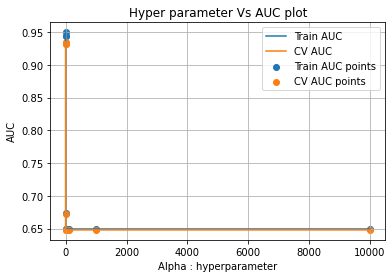

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.200958,0.006349,0.016475,0.001642,0.0001,{'alpha': 0.0001},0.939161,0.936409,0.927975,0.932994,0.940032,0.938909,0.930146,0.937800,0.936184,0.933922,0.935353,0.003821,1,0.949551,0.949890,0.950448,0.949928,0.949605,0.949489,0.949972,0.949551,0.949568,0.949812,0.949781,0.000280
1,0.167422,0.002496,0.017399,0.002993,0.001,{'alpha': 0.001},0.934442,0.930884,0.922019,0.929250,0.937578,0.936151,0.925786,0.934126,0.931682,0.929376,0.931129,0.004531,3,0.943208,0.943296,0.943896,0.943668,0.942982,0.943215,0.943642,0.943183,0.943233,0.943323,0.943365,0.000265
2,0.151980,0.004264,0.015957,0.000469,0.01,{'alpha': 0.01},0.934696,0.931388,0.922626,0.929321,0.937873,0.936084,0.925999,0.934408,0.931824,0.929789,0.931401,0.004439,2,0.943187,0.943302,0.944003,0.943651,0.942999,0.943242,0.943668,0.943200,0.943249,0.943289,0.943379,0.000285
3,0.360621,0.023838,0.015771,0.000320,0.1,{'alpha': 0.1},0.654612,0.681557,0.675346,0.652689,0.689635,0.677031,0.670142,0.677471,0.676632,0.665714,0.672083,0.010993,4,0.676471,0.669198,0.677673,0.675726,0.678343,0.674544,0.668354,0.675765,0.671488,0.674767,0.674233,0.003258
4,0.256873,0.003282,0.016171,0.001593,1,{'alpha': 1},0.629172,0.656839,0.649652,0.628492,0.659094,0.651818,0.651958,0.655019,0.654435,0.642596,0.647907,0.010436,5,0.651035,0.648404,0.649415,0.651321,0.648118,0.648790,0.648795,0.648285,0.648787,0.650157,0.649311,0.001089


In [38]:
results,best_alpha,linear_svm = SVM_Linear_SVM(X_Train_data_tfidf,Y_Train,'l2')
results.head()

### BEST ALPHA = 0.0001 & AUC SCORE = 0.9353 ON TRAINING DATA

In [39]:
best_alpha = Find_best_Alpha(best_alpha)

0.0001


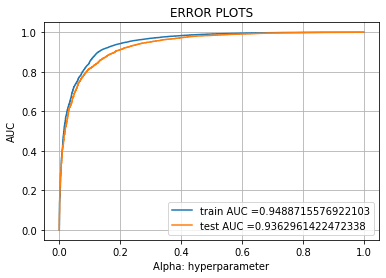

In [40]:
linear_svm = SGDClassifier(loss='hinge',penalty='l2',random_state=None, class_weight=None,alpha=best_alpha)
clf=linear_svm.fit(X_Train_data_tfidf,Y_Train)
calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
model_m=calibrated_model.fit(X_Train_data_tfidf,Y_Train)
pred_test_data=linear_svm.predict(X_Test_data_tfidf)
y_train_predicted_prob = model_m.predict_proba(X_Train_data_tfidf)[:,1]
y_test_predicted_prob=model_m.predict_proba(X_Test_data_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [41]:
feature_names = tfidf_vector.get_feature_names()
print(feature_names)
coefs_with_fns = sorted(zip(linear_svm.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

['abandon', 'abc', 'abdomin', 'abil', 'abl', 'abroad', 'absenc', 'absent', 'absolut', 'absolutley', 'absorb', 'absorpt', 'absurd', 'abund', 'abus', 'acacia', 'academi', 'acai', 'accent', 'accept', 'access', 'accid', 'accident', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accross', 'accur', 'accustom', 'acerola', 'ach', 'achiev', 'acid', 'acknowledg', 'acn', 'acquaint', 'acquir', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adagio', 'adam', 'adapt', 'add', 'addict', 'addit', 'address', 'adequ', 'adher', 'adhes', 'adjust', 'administ', 'administr', 'admir', 'admit', 'adobo', 'adopt', 'ador', 'adult', 'adulter', 'advanc', 'advantag', 'adventur', 'advers', 'advert', 'advertis', 'advic', 'advis', 'advoc', 'aerat', 'aero', 'aerogarden', 'aerogrow', 'aesthet', 'affair', 'affect', 'afficionado', 'affili', 'afford', 'afghanistan', 'aficionado', 'aforement', 'afraid', 'africa', 'african', 'afteral', 'afterlif', 'afternoon', 'aftertast', 'afterward

[((-3.5252305591227597, 'worst'), (3.1691492148895763, 'great')),
 ((-3.4005030003873884, 'disappoint'), (2.6431849273213213, 'best')),
 ((-3.011837811348974, 'return'), (2.346785762435066, 'love')),
 ((-2.8599641269962075, 'horribl'), (2.2155651378079484, 'delici')),
 ((-2.8490643379944345, 'terribl'), (1.973408817473574, 'good')),
 ((-2.6997285069022863, 'aw'), (1.8981549152660266, 'excel')),
 ((-2.551410076986622, 'threw'), (1.8505124817553666, 'perfect')),
 ((-2.2322630718087475, 'wast'), (1.8235615796747322, 'nice')),
 ((-2.222731395767679, 'stale'), (1.5899723194087558, 'wonder')),
 ((-2.1713121701828735, 'money'), (1.5875181466524377, 'amaz')),
 ((-2.1643257959150217, 'bland'), (1.554797524815107, 'favorit')),
 ((-2.0874293899363803, 'tasteless'), (1.3285533753518113, 'find')),
 ((-1.8424766374606494, 'refund'), (1.2952990206015922, 'awesom')),
 ((-1.8317515775148232, 'disgust'), (1.2663691707134266, 'tasti')),
 ((-1.8199214620059139, 'poor'), (1.2245791948877016, 'addict')),
 (

In [42]:
roc_auc_score(Y_Test,y_test_predicted_prob)

0.9362961422472338

In [43]:
print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.90      0.33      0.48      2457
    positive       0.91      0.99      0.95     17543

    accuracy                           0.91     20000
   macro avg       0.91      0.66      0.72     20000
weighted avg       0.91      0.91      0.89     20000

[[  804  1653]
 [   90 17453]]


### AND FOR BEST ALPHA = 0.0001 , AUC SCORE = 0.9326

### SVM on Amazon Fine Food Review using L1 Regularization

0.9180460072517856
{'alpha': 0.0001}


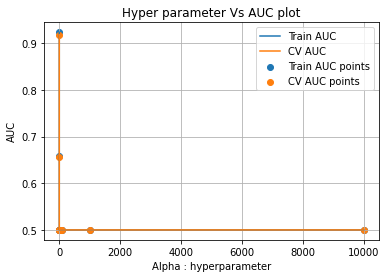

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.282197,0.004999,0.016205,0.000478,0.0001,{'alpha': 0.0001},0.921746,0.916210,0.909112,0.913916,0.926643,0.927430,0.909787,0.922245,0.918345,0.915027,0.918046,0.006091,1,0.921847,0.923029,0.923783,0.923499,0.922187,0.923344,0.924282,0.923365,0.923713,0.923309,0.923236,0.000692
1,0.201957,0.009141,0.016437,0.001334,0.001,{'alpha': 0.001},0.690765,0.649865,0.698954,0.675134,0.591752,0.656739,0.652650,0.644578,0.666500,0.643736,0.657067,0.028243,2,0.696083,0.656686,0.695040,0.691704,0.582553,0.648285,0.656190,0.637165,0.663133,0.648244,0.657508,0.032098
2,0.192060,0.007254,0.015663,0.000876,0.01,{'alpha': 0.01},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
3,1.452912,0.292737,0.014967,0.000299,0.1,{'alpha': 0.1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
4,0.337768,0.006949,0.016103,0.003331,1,{'alpha': 1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,3,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [65]:
results,best_alpha,linear_svm = SVM_Linear_SVM(X_Train_data_tfidf,Y_Train,'l1')
results.head()

## Avg Word2Vec Vectorization Technique on SUPPORT VECTOR MACHINE Algorithm

In [44]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

list_of_sent_train_avgw2v=[]
list_of_sent_test_avgw2v=[]
list_of_sent_cv_avgw2v=[]
for sent_train_avgw2v in tqdm(X_Train['Cleaned_text'].values):
    list_of_sent_train_avgw2v.append(sent_train_avgw2v.split())

100%|██████████| 64000/64000 [00:00<00:00, 78995.77it/s]


In [45]:
for sent_test_avgw2v in tqdm(X_Test['Cleaned_text'].values):
    list_of_sent_test_avgw2v.append(sent_test_avgw2v.split())
    
for sent_cv_avgw2v in tqdm(X_CV['Cleaned_text'].values):
    list_of_sent_cv_avgw2v.append(sent_cv_avgw2v.split())

100%|██████████| 16000/16000 [00:00<00:00, 189355.89it/s]


In [0]:
w2v_model_train = Word2Vec(list_of_sent_train_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_train=list(w2v_model_train.wv.vocab)

In [0]:
w2v_model_test = Word2Vec(list_of_sent_test_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_test=list(w2v_model_test.wv.vocab)

In [0]:
w2v_model_cv = Word2Vec(list_of_sent_cv_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svm_cv=list(w2v_model_cv.wv.vocab)

In [49]:
train_vectors=[];
for sent in list_of_sent_train_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

64000
50


In [50]:
test_vectors=[];
for sent in tqdm(list_of_sent_test_avgw2v):
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_test:
            vec=w2v_model_test.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

100%|██████████| 20000/20000 [00:16<00:00, 1200.95it/s]

20000
50


In [51]:
cv_vectors=[];
for sent in tqdm(list_of_sent_cv_avgw2v):
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svm_cv:
            vec=w2v_model_cv.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    cv_vectors.append(sent_vec)
print(len(cv_vectors))
print(len(cv_vectors[0]))

100%|██████████| 16000/16000 [00:12<00:00, 1257.27it/s]

16000
50


0.8893952681617303
{'alpha': 0.001}


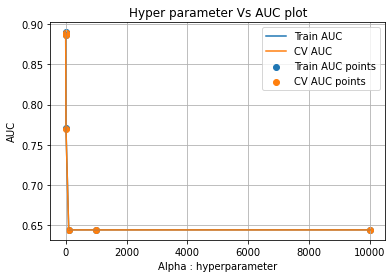

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.464100,0.050165,0.035754,0.003152,0.0001,{'alpha': 0.0001},0.887549,0.883522,0.876174,0.883653,0.889072,0.896112,0.878342,0.892268,0.891139,0.883561,0.886139,0.005936,5,0.886364,0.885942,0.884874,0.887671,0.887615,0.888057,0.889781,0.889092,0.886308,0.884447,0.887015,0.001646
1,0.268217,0.012332,0.034349,0.000384,0.001,{'alpha': 0.001},0.889850,0.887479,0.880921,0.887017,0.892587,0.898092,0.881385,0.891944,0.894036,0.890642,0.889395,0.005108,1,0.889885,0.889880,0.890562,0.890485,0.889927,0.889192,0.891202,0.890157,0.889015,0.889767,0.890007,0.000611
2,0.218326,0.003064,0.034603,0.000560,0.01,{'alpha': 0.01},0.890220,0.885638,0.878478,0.887563,0.890852,0.896796,0.880931,0.891498,0.893762,0.890733,0.888647,0.005344,2,0.889299,0.889079,0.889018,0.889712,0.888855,0.888060,0.890548,0.889028,0.889007,0.889030,0.889164,0.000603
3,0.218255,0.016672,0.035085,0.000583,0.1,{'alpha': 0.1},0.888572,0.885529,0.880450,0.887286,0.888124,0.897254,0.879976,0.891845,0.892411,0.890052,0.888150,0.005022,3,0.887588,0.889083,0.890330,0.889466,0.887265,0.888544,0.890614,0.888387,0.887132,0.888720,0.888713,0.001137
4,0.207437,0.010266,0.035847,0.000986,1,{'alpha': 1},0.880606,0.884347,0.879358,0.887112,0.892321,0.895506,0.880452,0.893488,0.894533,0.887720,0.887544,0.005885,4,0.881699,0.888705,0.889698,0.890123,0.890002,0.887624,0.891099,0.890391,0.889595,0.887235,0.888617,0.002576


In [52]:
results,best_alpha,linear_svm = SVM_Linear_SVM(train_vectors,Y_Train,'l2')
results.head()

### BEST ALPHA = 0.001 WITH AUC = 0.8890 ON TRAINING DATA 

In [53]:
best_alpha = Find_best_Alpha(best_alpha)

0.001


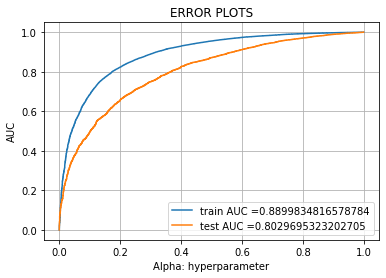

In [54]:
linear_svm = SGDClassifier(loss='hinge',penalty='l2',random_state=None, class_weight=None,alpha=best_alpha)
clf=linear_svm.fit(train_vectors,Y_Train)
calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
model_m=calibrated_model.fit(train_vectors,Y_Train)
pred_test_data=linear_svm.predict(test_vectors)
y_train_predicted_prob = model_m.predict_proba(train_vectors)[:,1]
y_test_predicted_prob=model_m.predict_proba(test_vectors)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### TEST AUC = 0.80326 FOR ALPHA = 0.001

### SVM on Amazon Fine Food REview using L1 Regularization

0.8868313361702558
{'alpha': 0.001}


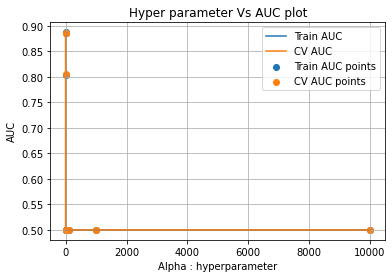

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.615362,0.034282,0.029011,0.000364,0.0001,{'alpha': 0.0001},0.888781,0.881898,0.875960,0.883712,0.883236,0.894064,0.879500,0.890962,0.890434,0.886177,0.885472,0.005358,2,0.887300,0.888043,0.888076,0.888936,0.884141,0.887229,0.888883,0.887697,0.884403,0.884700,0.886941,0.001742
1,0.338329,0.021439,0.029690,0.001517,0.001,{'alpha': 0.001},0.887724,0.883048,0.878874,0.886820,0.886981,0.896359,0.876366,0.890485,0.891768,0.889889,0.886831,0.005708,1,0.887394,0.886849,0.889467,0.889098,0.886191,0.887887,0.888018,0.887769,0.886650,0.887519,0.887684,0.000972
2,0.306859,0.007375,0.029253,0.000761,0.01,{'alpha': 0.01},0.830911,0.799298,0.779361,0.844644,0.755345,0.831588,0.827019,0.787504,0.856778,0.736814,0.804926,0.037718,3,0.830552,0.804087,0.789898,0.849577,0.747111,0.824117,0.835001,0.776012,0.844306,0.744002,0.804466,0.036863
3,0.272682,0.004794,0.028153,0.000324,0.1,{'alpha': 0.1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,4,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
4,0.279753,0.009730,0.029353,0.001307,1,{'alpha': 1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,4,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [66]:
results,best_alpha,linear_svm = SVM_Linear_SVM(train_vectors,Y_Train,'l1')
results.head()

## TF-IDF Word2Vec Vectorization Technique for SUPPORT VECTOR MACHINE on Amazon Fine Food Review

In [0]:
model_Avgw2v = TfidfVectorizer()
X_Train_Avgw2v=model_Avgw2v.fit_transform(X_Train['Cleaned_text'].values)

In [0]:
X_Test_Avgw2v=model_Avgw2v.transform(X_Test['Cleaned_text'].values)
X_CV_Avgw2v=model_Avgw2v.transform(X_CV['Cleaned_text'].values)

In [0]:
dictionary = dict(zip(model_Avgw2v.get_feature_names(), list(model_Avgw2v.idf_)))

In [59]:
tfidf_feature=model_Avgw2v.get_feature_names()

tfidf_sent_vectors_train=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_train_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svm_train and word in tfidf_feature :
            vec=w2v_model_train.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1

100%|██████████| 64000/64000 [14:28<00:00, 73.65it/s]


In [60]:
tfidf_sent_vectors_test=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_test_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svm_test and word in tfidf_feature :
            vec=w2v_model_test.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

100%|██████████| 20000/20000 [04:23<00:00, 75.82it/s]


0.8593906637211086
{'alpha': 0.001}


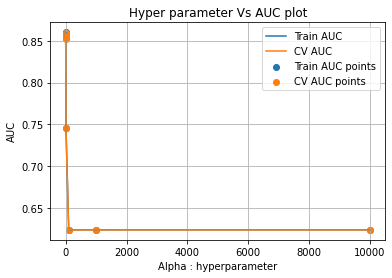

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.593249,0.028793,0.035492,0.001220,0.0001,{'alpha': 0.0001},0.848499,0.851303,0.836099,0.853418,0.857514,0.868311,0.845165,0.853515,0.856048,0.850601,0.852047,0.007946,5,0.856308,0.853547,0.857890,0.855463,0.851106,0.857294,0.852448,0.853313,0.850710,0.850231,0.853831,0.002639
1,0.310280,0.012341,0.035850,0.002070,0.001,{'alpha': 0.001},0.856023,0.856141,0.847199,0.862054,0.859933,0.869437,0.851680,0.864917,0.867611,0.858912,0.859391,0.006608,1,0.861183,0.859732,0.862182,0.858996,0.854186,0.860797,0.863993,0.863135,0.860418,0.857380,0.860200,0.002722
2,0.234241,0.006350,0.035853,0.001414,0.01,{'alpha': 0.01},0.855193,0.855017,0.843946,0.860483,0.864631,0.867118,0.849252,0.862089,0.869349,0.860332,0.858741,0.007547,2,0.860834,0.861391,0.860483,0.858296,0.858662,0.856231,0.861139,0.859692,0.862809,0.855617,0.859516,0.002189
3,0.230646,0.004971,0.034734,0.001037,0.1,{'alpha': 0.1},0.842829,0.852369,0.845684,0.859789,0.864836,0.865830,0.846105,0.859525,0.854919,0.859698,0.855159,0.007747,4,0.845381,0.859855,0.857774,0.860208,0.856189,0.855720,0.857429,0.859884,0.848969,0.860219,0.856163,0.004824
4,0.212810,0.006187,0.035471,0.001092,1,{'alpha': 1},0.854022,0.850975,0.842623,0.858871,0.870247,0.862384,0.847192,0.863654,0.864881,0.853875,0.856872,0.008198,3,0.858807,0.856525,0.859927,0.857756,0.861875,0.854912,0.859369,0.861290,0.859999,0.858289,0.858875,0.002007


In [61]:
results,best_alpha,linear_svm = SVM_Linear_SVM(tfidf_sent_vectors_train,Y_Train,'l2')
results.head()

### BEST ALPHA = 0.001 WITH AUC = 0.8593 ON TRAINING DATA

In [62]:
best_alpha = Find_best_Alpha(best_alpha)

0.001


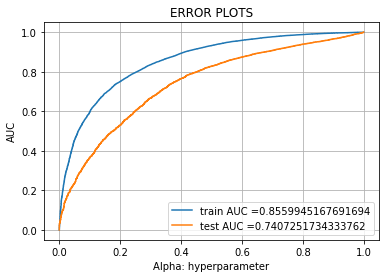

In [63]:
linear_svm = SGDClassifier(loss='hinge',penalty='l2',random_state=None, class_weight=None,alpha=best_alpha)
clf=linear_svm.fit(tfidf_sent_vectors_train,Y_Train)
calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
model_m=calibrated_model.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=linear_svm.predict(tfidf_sent_vectors_test)
y_train_predicted_prob = model_m.predict_proba(tfidf_sent_vectors_train)[:,1]
y_test_predicted_prob=model_m.predict_proba(tfidf_sent_vectors_test)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

0.8519893373085686
{'alpha': 0.0001}


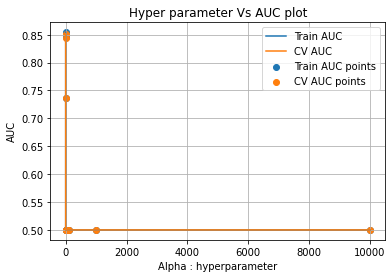

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.788327,0.064601,0.029334,0.000754,0.0001,{'alpha': 0.0001},0.848334,0.846710,0.838456,0.853877,0.856067,0.869993,0.844225,0.848959,0.859659,0.853614,0.851989,0.008364,1,0.855632,0.854162,0.855496,0.855455,0.850135,0.859555,0.856158,0.849709,0.849791,0.858182,0.854427,0.003306
1,0.390466,0.020528,0.029376,0.001168,0.001,{'alpha': 0.001},0.843245,0.829781,0.841121,0.856369,0.845543,0.857945,0.818414,0.849116,0.856196,0.847913,0.844564,0.011843,2,0.849203,0.839783,0.853734,0.854236,0.838896,0.846293,0.831456,0.847519,0.844316,0.849422,0.845486,0.006729
2,0.308332,0.004531,0.029242,0.000428,0.01,{'alpha': 0.01},0.618617,0.717146,0.771726,0.763833,0.696168,0.769762,0.723748,0.794815,0.726650,0.774063,0.735653,0.049047,3,0.607695,0.724105,0.782306,0.764427,0.706307,0.761902,0.733732,0.793835,0.715777,0.778498,0.736858,0.051640
3,0.272443,0.007234,0.027860,0.000470,0.1,{'alpha': 0.1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,4,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
4,0.271363,0.005789,0.028100,0.000459,1,{'alpha': 1},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,4,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [67]:
results,best_alpha,linear_svm = SVM_Linear_SVM(tfidf_sent_vectors_train,Y_Train,'l1')
results.head()

# IMPLEMENT SUPPORT VECTOR MACHINE USING RBF KERNEL

### SPLIT THE DATA INTO TRAIN , TEST & CV

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_1,X_Test_RBF,Y_1,Y_Test_RBF = train_test_split(final_data_40K,amazon_polarity_labels_40K,test_size=0.2,random_state=0)
X_Train_RBF,X_CV_RBF,Y_Train_RBF,Y_CV_RBF = train_test_split(X_1,Y_1,test_size=0.2)

In [22]:
print(X_Train_RBF.shape, Y_Train_RBF.shape)
print(X_CV_RBF.shape, Y_CV_RBF.shape)
print(X_Test_RBF.shape, Y_Test_RBF.shape)

print("="*100)


count_vector=CountVectorizer(min_df=10,max_features=500)
X_Train_data_bow_rbf=(count_vector.fit_transform(X_Train_RBF['Cleaned_text'].values))
X_Test_data_bow_rbf=(count_vector.transform(X_Test_RBF['Cleaned_text'].values))
X_CV_data_bow_rbf=(count_vector.transform(X_CV_RBF['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_bow_rbf.shape, Y_Train_RBF.shape)
print(X_CV_data_bow_rbf.shape, Y_CV_RBF.shape)
print(X_Test_data_bow_rbf.shape, Y_Test_RBF.shape)
print("="*100)

(19200, 12) (19200,)
(4800, 12) (4800,)
(6000, 12) (6000,)
After vectorizations
(19200, 500) (19200,)
(4800, 500) (4800,)
(6000, 500) (6000,)


In [0]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def RBF_SVM(x_training_data,y_training_data):
  grid_params = { 'C' : [10**x for x in range(-4,5)]              
                 }
  rbf_SVM = SVC(kernel='rbf',random_state=None, class_weight=None)
  clf=GridSearchCV(rbf_SVM,grid_params,scoring='roc_auc',return_train_score=True,cv=3)
  clf.fit(x_training_data,y_training_data)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_C'])
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']
  best_c =  results['param_C']  
  print(clf.best_score_)
  print(clf.best_params_)
  plt.plot(best_c, train_auc, label='Train AUC')
  plt.plot(best_c, cv_auc, label='CV AUC')
  plt.scatter(best_c, train_auc, label='Train AUC points')
  plt.scatter(best_c, cv_auc, label='CV AUC points')
  plt.legend()
  plt.xlabel("C = 1/Alpha : hyperparameter")
  plt.ylabel("AUC")
  plt.title("Hyper parameter Vs AUC plot")
  plt.grid()
  plt.show()
  return results,clf,rbf_SVM

0.8744640078013962
{'C': 1}


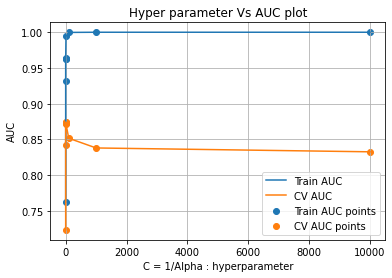

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,8.881859,0.075935,3.833624,0.016110,0.0001,{'C': 0.0001},0.726542,0.715834,0.728098,0.723491,0.005452,9,0.769786,0.754477,0.762552,0.762272,0.006253
1,11.182248,0.074443,4.521126,0.398858,0.001,{'C': 0.001},0.841201,0.845609,0.840488,0.842432,0.002265,6,0.932135,0.930310,0.931927,0.931458,0.000816
2,16.277469,0.170417,6.572980,0.049068,0.01,{'C': 0.01},0.872069,0.876223,0.872834,0.873709,0.001805,3,0.964185,0.963089,0.959784,0.962353,0.001871
3,16.762876,0.292377,7.022699,0.063776,0.1,{'C': 0.1},0.872636,0.876598,0.873413,0.874215,0.001714,2,0.964710,0.962667,0.960008,0.962462,0.001925
4,16.579718,0.298460,7.122815,0.083631,1,{'C': 1},0.873039,0.876679,0.873674,0.874464,0.001587,1,0.965867,0.964062,0.960565,0.963498,0.002201


In [26]:
results,best_one_by_alpha,rbf_svm = RBF_SVM(X_Train_data_bow_rbf,Y_Train_RBF)
results.head()

In [0]:
def Find_best_C(best_c) :
  best_C = best_c.best_params_
  best_C=best_C.get("C")
  print(best_C)
  return best_C

In [28]:
best_c = Find_best_C(best_one_by_alpha)

1


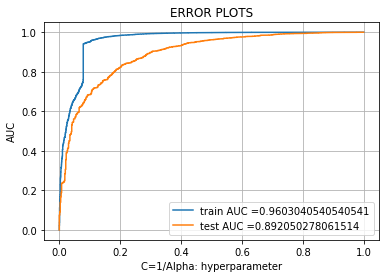

In [43]:
rbf_svm = SVC(C=best_c, kernel='rbf',random_state=None, class_weight=None,probability=True)
rbf_svm.fit(X_Train_data_bow_rbf,Y_Train_RBF)
  #calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
  #model_m=calibrated_model.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=rbf_svm.predict(X_Test_data_bow_rbf)
y_train_predicted_prob = rbf_svm.predict_proba(X_Train_data_bow_rbf)[:,1]
y_test_predicted_prob=rbf_svm.predict_proba(X_Test_data_bow_rbf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train_RBF,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test_RBF, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C=1/Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

roc_auc_score(Y_Test_RBF,y_test_predicted_prob)

0.892050278061514

In [45]:
print(classification_report(Y_Test_RBF,pred_test_data))
print(confusion_matrix(Y_Test_RBF,pred_test_data))

              precision    recall  f1-score   support

    negative       0.87      0.14      0.24       660
    positive       0.90      1.00      0.95      5340

    accuracy                           0.90      6000
   macro avg       0.89      0.57      0.60      6000
weighted avg       0.90      0.90      0.87      6000

[[  93  567]
 [  14 5326]]


# SUPPORT VECTOR MACHINE TFIDF VECTORIZATION TECHNIQUE FOR RBF KERNAL

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_Train_RBF.shape, Y_Train_RBF.shape)
print(X_CV_RBF.shape, Y_CV_RBF.shape)
print(X_Test_RBF.shape, Y_Test_RBF.shape)

print("="*100)


tfidf_vector=TfidfVectorizer(min_df=10,max_features=500)
X_Train_data_tfidf=(tfidf_vector.fit_transform(X_Train_RBF['Cleaned_text'].values))
X_Test_data_tfidf=(tfidf_vector.transform(X_Test_RBF['Cleaned_text'].values))
X_CV_data_tfidf=(tfidf_vector.transform(X_CV_RBF['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_tfidf.shape, Y_Train_RBF.shape)
print(X_CV_data_tfidf.shape, Y_CV_RBF.shape)
print(X_Test_data_tfidf.shape, Y_Test_RBF.shape)
print("="*100)

(19200, 12) (19200,)
(4800, 12) (4800,)
(6000, 12) (6000,)
After vectorizations
(19200, 500) (19200,)
(4800, 500) (4800,)
(6000, 500) (6000,)


0.8933775480843108
{'C': 10}


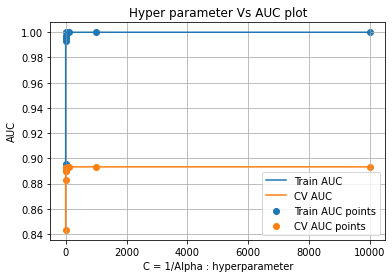

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,8.389556,0.094299,3.762124,0.025662,0.0001,{'C': 0.0001},0.848933,0.840479,0.840470,0.843294,0.003987,9,0.895686,0.892141,0.898582,0.895470,0.002634
1,11.170771,0.033705,4.209851,0.006669,0.001,{'C': 0.001},0.882891,0.887146,0.878327,0.882788,0.003601,8,0.993801,0.992939,0.992014,0.992918,0.000730
2,15.728408,0.163814,5.994792,0.052254,0.01,{'C': 0.01},0.888252,0.895843,0.886702,0.890265,0.003994,6,0.996269,0.996709,0.994697,0.995892,0.000864
3,15.862320,0.210091,6.360304,0.062101,0.1,{'C': 0.1},0.888043,0.895994,0.886678,0.890238,0.004108,7,0.996084,0.996676,0.994707,0.995822,0.000825
4,15.695362,0.228676,6.734292,0.308750,1,{'C': 1},0.889058,0.897087,0.888463,0.891536,0.003933,5,0.997202,0.997730,0.996002,0.996978,0.000723


In [48]:
results,best_one_by_alpha,rbf_svm = RBF_SVM(X_Train_data_tfidf,Y_Train_RBF)
results.head()

In [49]:
best_c = Find_best_C(best_one_by_alpha)

10


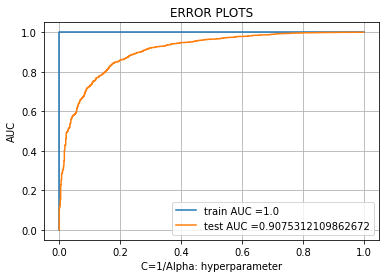

In [50]:
rbf_svm = SVC(C=best_c, kernel='rbf',random_state=None, class_weight=None,probability=True)
rbf_svm.fit(X_Train_data_tfidf,Y_Train_RBF)
  #calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
  #model_m=calibrated_model.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=rbf_svm.predict(X_Test_data_tfidf)
y_train_predicted_prob = rbf_svm.predict_proba(X_Train_data_tfidf)[:,1]
y_test_predicted_prob=rbf_svm.predict_proba(X_Test_data_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train_RBF,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test_RBF, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C=1/Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [51]:
roc_auc_score(Y_Test_RBF,y_test_predicted_prob)

0.9075312109862672

In [52]:
print(classification_report(Y_Test_RBF,pred_test_data))
print(confusion_matrix(Y_Test_RBF,pred_test_data))

              precision    recall  f1-score   support

    negative       0.73      0.37      0.49       660
    positive       0.93      0.98      0.95      5340

    accuracy                           0.92      6000
   macro avg       0.83      0.67      0.72      6000
weighted avg       0.90      0.92      0.90      6000

[[ 241  419]
 [  88 5252]]


#AVERAGE WORD2VEC VECTORIZATION TECHNIQUE USING RFB KERNEL

In [21]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

list_of_sent_train_avgw2v=[]
list_of_sent_test_avgw2v=[]
list_of_sent_cv_avgw2v=[]
for sent_train_avgw2v in tqdm(X_Train_RBF['Cleaned_text'].values):
    list_of_sent_train_avgw2v.append(sent_train_avgw2v.split())

100%|██████████| 19200/19200 [00:00<00:00, 170831.10it/s]


In [22]:
for sent_test_avgw2v in tqdm(X_Test_RBF['Cleaned_text'].values):
    list_of_sent_test_avgw2v.append(sent_test_avgw2v.split())
    
for sent_cv_avgw2v in tqdm(X_CV_RBF['Cleaned_text'].values):
    list_of_sent_cv_avgw2v.append(sent_cv_avgw2v.split())

100%|██████████| 4800/4800 [00:00<00:00, 165923.50it/s]


In [0]:
w2v_model_train = Word2Vec(list_of_sent_train_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svmrbf_train=list(w2v_model_train.wv.vocab)

In [0]:
w2v_model_test = Word2Vec(list_of_sent_test_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svmrbf_test=list(w2v_model_test.wv.vocab)

In [0]:
w2v_model_cv = Word2Vec(list_of_sent_cv_avgw2v,min_count=5,size=50,workers=4)
w2v_words_svmrbf_cv=list(w2v_model_cv.wv.vocab)

In [30]:
train_vectors=[];
for sent in list_of_sent_train_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svmrbf_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

19200
50


In [31]:
test_vectors=[];
for sent in list_of_sent_test_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svmrbf_test:
            vec=w2v_model_test.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0])) 

6000
50


In [32]:
cv_vectors=[];
for sent in list_of_sent_cv_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_svmrbf_cv:
            vec=w2v_model_cv.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    cv_vectors.append(sent_vec)
print(len(cv_vectors))
print(len(cv_vectors[0]))

4800
50


0.854387844023114
{'C': 10}


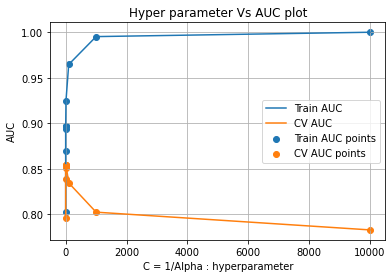

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.219129,0.043246,1.662449,0.004553,0.0001,{'C': 0.0001},0.798200,0.805065,0.785252,0.796172,0.008215,8,0.815664,0.795283,0.798056,0.803001,0.009025
1,4.590138,0.026659,1.666605,0.004292,0.001,{'C': 0.001},0.844461,0.842435,0.830560,0.839152,0.006131,5,0.882493,0.863237,0.863044,0.869591,0.009123
2,5.761482,0.085106,1.824312,0.001734,0.01,{'C': 0.01},0.851311,0.850887,0.851822,0.851340,0.000382,4,0.900960,0.888504,0.892587,0.894017,0.005185
3,5.973886,0.087304,2.019669,0.227633,0.1,{'C': 0.1},0.853838,0.855393,0.853069,0.854100,0.000966,2,0.903149,0.892283,0.894486,0.896639,0.004690
4,5.691197,0.070469,1.847777,0.007446,1,{'C': 1},0.854072,0.855142,0.852993,0.854069,0.000877,3,0.903398,0.892247,0.894482,0.896709,0.004817


In [35]:
results,best_one_by_alpha,rbf_svm = RBF_SVM(train_vectors,Y_Train_RBF)
results.head()

In [38]:
best_c = Find_best_C(best_one_by_alpha)

10


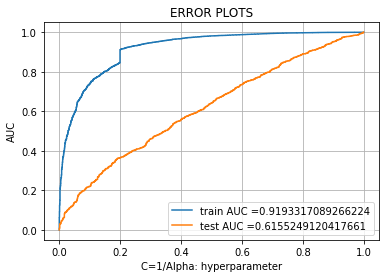

In [39]:
rbf_svm = SVC(C=best_c, kernel='rbf',random_state=None, class_weight=None,probability=True)
rbf_svm.fit(train_vectors,Y_Train_RBF)
  #calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
  #model_m=calibrated_model.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=rbf_svm.predict(test_vectors)
y_train_predicted_prob = rbf_svm.predict_proba(train_vectors)[:,1]
y_test_predicted_prob=rbf_svm.predict_proba(test_vectors)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train_RBF,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test_RBF, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C=1/Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

roc_auc_score(Y_Test_RBF,y_test_predicted_prob)

0.6155249120417661

In [41]:
  print(classification_report(Y_Test_RBF,pred_test_data))
  print(confusion_matrix(Y_Test_RBF,pred_test_data))

              precision    recall  f1-score   support

    negative       0.14      0.00      0.00       660
    positive       0.89      1.00      0.94      5340

    accuracy                           0.89      6000
   macro avg       0.52      0.50      0.47      6000
weighted avg       0.81      0.89      0.84      6000

[[   1  659]
 [   6 5334]]


# TF-IDF Average Word2Vec using RBF Kernel

In [0]:
model_Avgw2v = TfidfVectorizer()
X_Train_Avgw2v=model_Avgw2v.fit_transform(X_Train_RBF['Cleaned_text'].values)

In [0]:
X_Test_Avgw2v=model_Avgw2v.transform(X_Test_RBF['Cleaned_text'].values)
X_CV_Avgw2v=model_Avgw2v.transform(X_CV_RBF['Cleaned_text'].values)

In [0]:
dictionary = dict(zip(model_Avgw2v.get_feature_names(), list(model_Avgw2v.idf_)))

In [45]:
tfidf_feature=model_Avgw2v.get_feature_names()

tfidf_sent_vectors_train=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_train_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svmrbf_train and word in tfidf_feature :
            vec=w2v_model_train.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1

100%|██████████| 19200/19200 [02:15<00:00, 141.21it/s]


In [46]:
tfidf_sent_vectors_test=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_test_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_svmrbf_test and word in tfidf_feature :
            vec=w2v_model_test.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

100%|██████████| 6000/6000 [00:40<00:00, 148.81it/s]


0.8291443099232637
{'C': 10}


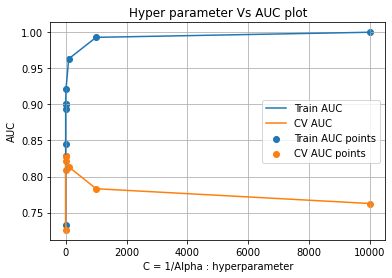

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.131723,0.030522,1.669118,0.010235,0.0001,{'C': 0.0001},0.724419,0.721951,0.731732,0.726034,0.004153,9,0.736089,0.721576,0.740300,0.732655,0.008021
1,4.467314,0.044934,1.671763,0.007991,0.001,{'C': 0.001},0.784976,0.826774,0.816240,0.809330,0.017750,6,0.835439,0.846053,0.852750,0.844747,0.007127
2,5.640827,0.061905,1.883818,0.011674,0.01,{'C': 0.01},0.820578,0.813984,0.832054,0.822205,0.007466,4,0.892509,0.888347,0.898711,0.893189,0.004258
3,6.628933,0.044802,1.990721,0.026210,0.1,{'C': 0.1},0.830384,0.822480,0.830648,0.827837,0.003790,3,0.901271,0.896983,0.904143,0.900799,0.002942
4,6.555834,0.098492,1.970353,0.011784,1,{'C': 1},0.831317,0.822509,0.830220,0.828015,0.003920,2,0.901631,0.896533,0.903700,0.900621,0.003012


In [47]:
results,best_one_by_alpha,rbf_svm = RBF_SVM(tfidf_sent_vectors_train,Y_Train_RBF)
results.head()

In [48]:
best_c = Find_best_C(best_one_by_alpha)

10


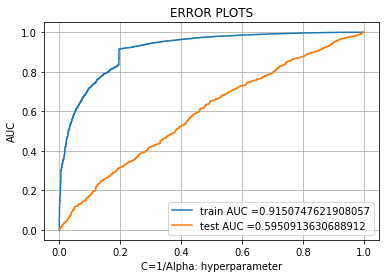

In [49]:
rbf_svm = SVC(C=best_c, kernel='rbf',random_state=None, class_weight=None,probability=True)
rbf_svm.fit(tfidf_sent_vectors_train,Y_Train_RBF)
  #calibrated_model=CalibratedClassifierCV(clf,cv='prefit')
  #model_m=calibrated_model.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=rbf_svm.predict(tfidf_sent_vectors_test)
y_train_predicted_prob = rbf_svm.predict_proba(tfidf_sent_vectors_train)[:,1]
y_test_predicted_prob=rbf_svm.predict_proba(tfidf_sent_vectors_test)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train_RBF,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test_RBF, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C=1/Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [50]:
roc_auc_score(Y_Test_RBF,y_test_predicted_prob)

0.5950913630688912

In [51]:
print(classification_report(Y_Test_RBF,pred_test_data))
print(confusion_matrix(Y_Test_RBF,pred_test_data))

              precision    recall  f1-score   support

    negative       0.16      0.01      0.01       660
    positive       0.89      0.99      0.94      5340

    accuracy                           0.89      6000
   macro avg       0.52      0.50      0.48      6000
weighted avg       0.81      0.89      0.84      6000

[[   5  655]
 [  27 5313]]


# PRETTY TABLE

In [52]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp36-none-any.whl size=22908 sha256=34e773e9cf72ff9c2b6259e9be27fc457218313d2d628370fb7f9f2e094e8a8c
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [53]:
from prettytable import PrettyTable

x= PrettyTable()
x.field_names = ["Vectorizer" , "Hyperparameter(Alpha/C)", "AUC","Regularization","Kernel"]
x.add_row(["Bag Of Words",0.001,0.9266,'L2',"Linear SVM"])
x.add_row(["Bag Of Words",0.0001,0.8836,'L1',"Linear SVM"])
x.add_row(["Tf-Idf",0.0001,0.9353,"L2","Linear SVM"])
x.add_row(["Tf-Idf",0.0001,0.9180,"L1","Linear SVM"])
x.add_row(["Avg Word2Vec",0.001,0.8893,"L2","Linear SVM"])
x.add_row(["Avg Word2Vec",0.001,0.8868,"L1","Linear SVM"])
x.add_row(["TF-IDF Word2Vec",0.001,0.8593,"L2","Linear SVM"])
x.add_row(["TF-IDF Word2Vec",0.0001,0.8519,"L1","Linear SVM"])
x.add_row(["Bag Of Words ",1,0.8744,"N/A","RBF SVM"])
x.add_row(["TF-IDF ",10,0.8933,"N/A","RBF SVM"])
x.add_row(["Avg Word2Vec ",10,0.8543,"N/A","RBF SVM"])
x.add_row(["TF-IDF Word2Vec ",10,0.82914,"N/A","RBF SVM"])
print(x)

+------------------+-------------------------+---------+----------------+------------+
|    Vectorizer    | Hyperparameter(Alpha/C) |   AUC   | Regularization |   Kernel   |
+------------------+-------------------------+---------+----------------+------------+
|   Bag Of Words   |          0.001          |  0.9266 |       L2       | Linear SVM |
|   Bag Of Words   |          0.0001         |  0.8836 |       L1       | Linear SVM |
|      Tf-Idf      |          0.0001         |  0.9353 |       L2       | Linear SVM |
|      Tf-Idf      |          0.0001         |  0.918  |       L1       | Linear SVM |
|   Avg Word2Vec   |          0.001          |  0.8893 |       L2       | Linear SVM |
|   Avg Word2Vec   |          0.001          |  0.8868 |       L1       | Linear SVM |
| TF-IDF Word2Vec  |          0.001          |  0.8593 |       L2       | Linear SVM |
| TF-IDF Word2Vec  |          0.0001         |  0.8519 |       L1       | Linear SVM |
|  Bag Of Words    |            1          

### CONCLUSION : IT HAS BEEN OBSERVED THAT 

### 1) FOR RBF KERNEL , AS C INCREASES , THE AUC SCORE DECREASES ON TEST DATA
### 2) FOR LINEAR SVM , THERE IS SLIGHTLY DECREASE IN AUC SCORE
### 3)* FOR LINEAR SVM :THE BEST ALPHA = 0.0001 AND AUC SCORE = 0.9353 USING TF-IDF VECTORIZATION TECHNIQUE USING L2 REGULARIZATION*
### 4) FOR RBF SVM , BEST C = 10 AND AUC SCORE = 0.8933 USING TF-IDF VECTORIZATION TECHNIQUE WITH 3 -FOLD CROSS VALIDATION